In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

from IPython import display

TensorFlow 2.x selected.


In [3]:
project_dir = '.'
weights_dir = os.path.join(project_dir, 'weights')
records_path = os.path.join(project_dir, 'all_images.tfrecords')
results_path = os.path.join(project_dir, 'results')
models_path = os.path.join(project_dir, 'models')
batch_size = 64

In [0]:
import sys
sys.path.append(models_path)
from generator import Generator
from discriminator import Discriminator

In [0]:
def decode(serialized_example):
    """
    Parses an image and label from the given `serialized_example`.
    It is used as a map function for `dataset.map`
    """

    # 1. define a parser
    features = tf.compat.v1.parse_single_example(
        serialized_example,
        features={
            'height': tf.compat.v1.FixedLenFeature([], tf.int64),
            'width': tf.compat.v1.FixedLenFeature([], tf.int64),
            'channels': tf.compat.v1.FixedLenFeature([], tf.int64),
            'image_raw': tf.compat.v1.FixedLenFeature([], tf.string)
        })
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    channels = tf.cast(features['channels'], tf.int32)
    image = tf.compat.v1.decode_raw(features['image_raw'], tf.uint8)
    image = tf.reshape(image, (64, 64, 3))
    return image

In [0]:
def normalize(image):
    image = tf.cast(image, tf.float32) / 255.
    return image

In [0]:
dataset = tf.data.TFRecordDataset(records_path)
dataset = dataset.map(decode)
dataset = dataset.map(normalize)
dataset = dataset.batch(batch_size)

In [0]:
generator_object = Generator((100, ))
discriminator_object = Discriminator((64, 64, 3))

In [0]:
generator = generator_object.get_model()
discriminator = discriminator_object.get_model()

In [0]:
# weights = os.listdir(weights_dir)
# if 'generator_weights.h5' in weights:
#     generator.load_weights(os.path.join(weights_dir, 'generator_weights.h5'))
# if 'discriminator_weights.h5' in weights:
#     discriminator.load_weights(os.path.join(weights_dir, 'discriminator_weights.h5'))

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


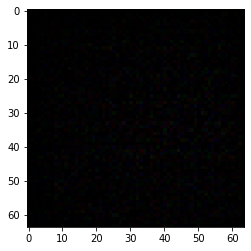

In [12]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, :])

In [0]:
def save_results(epoch):
    path = results_path
    noise = tf.random.normal([9, 100], seed=0)
    generated_imgs = generator(noise, training=False).numpy()
    plt.figure(figsize=(10, 10))
    for i in range(generated_imgs.shape[0]):
      plt.subplot(3, 3, i+1)
      plt.imshow(generated_imgs[i, :, :, :])
      plt.axis('off')
    plt.savefig(path + '/image_at_epoch_{:04d}.png'.format(epoch))
    plt.close()

In [0]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_object.get_loss(fake_output)
        disc_loss = discriminator_object.get_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(epochs):
    for i in range(1, epochs+1):
        for im_batch in dataset:
            train_step(im_batch)
        display.clear_output(wait=True)
        save_results(i)
        if i % 5 == 0:
            generator.save_weights(os.path.join(weights_dir, 'generator_weights.h5'), overwrite=True)
            discriminator.save_weights(os.path.join(weights_dir, 'discriminator_weights.h5'), overwrite=True)

In [16]:
train(50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
